#  WEEK 1: PlantVillage Dataset — Exploratory Data Analysis (EDA)

This notebook performs an exploratory data analysis (EDA) on the PlantVillage image dataset.
The goal is to understand dataset structure, class distribution, image characteristics,
and potential challenges before model development.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

plt.style.use("seaborn-v0_8")


## Dataset Structure

The dataset is organized in a folder-based format where each subfolder corresponds
to a plant disease class. Folder names act as class labels.


In [2]:
DATASET_PATH = "/kaggle/input/plantvillage-dataset/color"

classes = sorted(os.listdir(DATASET_PATH))
print(f"Total number of classes: {len(classes)}")
classes[:10]


Total number of classes: 38


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight']

**Convert Dataset → DataFrame**

In [3]:
data = []

for cls in classes:
    cls_path = os.path.join(DATASET_PATH, cls)
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        with Image.open(img_path) as img:
            width, height = img.size
        data.append([img_path, cls, width, height])

df = pd.DataFrame(data, columns=["image_path", "class", "width", "height"])
df.head()


,image_path,class,width,height
0,/kaggle/input/plantvillage-dataset/color/Apple...,Apple___Apple_scab,256,256
1,/kaggle/input/plantvillage-dataset/color/Apple...,Apple___Apple_scab,256,256
2,/kaggle/input/plantvillage-dataset/color/Apple...,Apple___Apple_scab,256,256
3,/kaggle/input/plantvillage-dataset/color/Apple...,Apple___Apple_scab,256,256
4,/kaggle/input/plantvillage-dataset/color/Apple...,Apple___Apple_scab,256,256


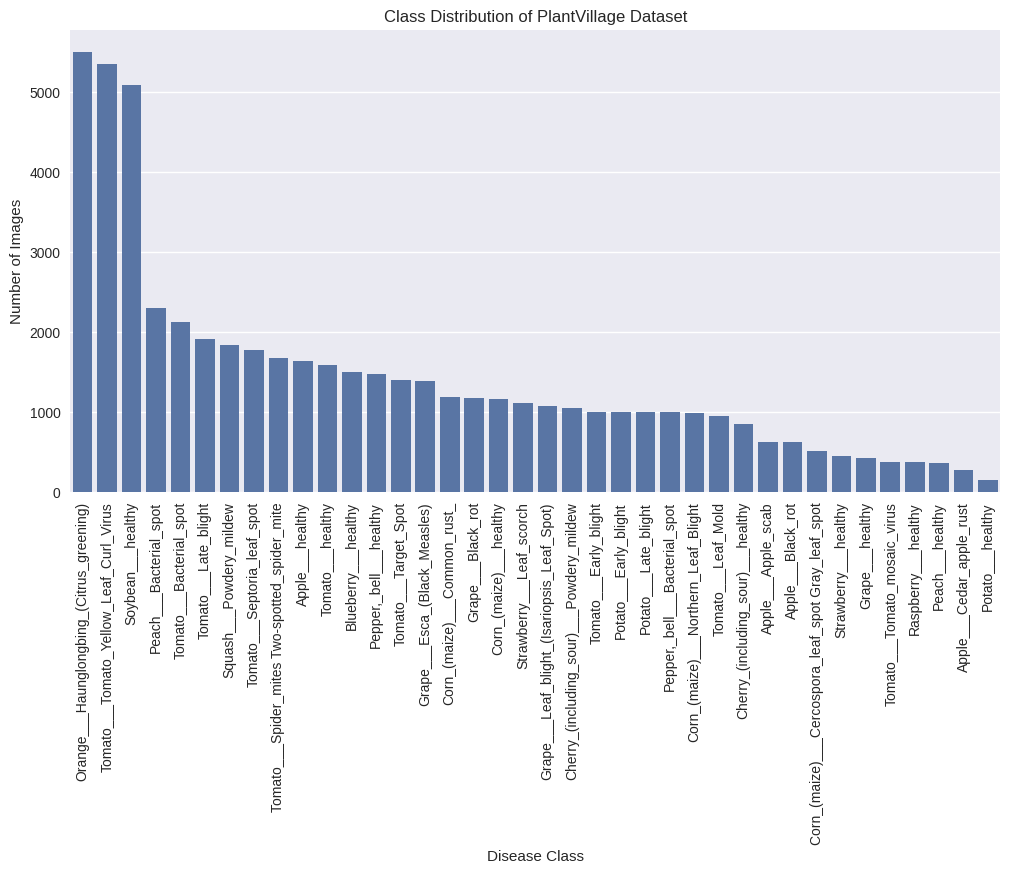

In [4]:
plt.figure(figsize=(12, 6))
class_counts = df["class"].value_counts()

sns.barplot(
    x=class_counts.index,
    y=class_counts.values
)
plt.xticks(rotation=90)
plt.title("Class Distribution of PlantVillage Dataset")
plt.ylabel("Number of Images")
plt.xlabel("Disease Class")
plt.show()



****### Class Distribution ObservationsThe dataset shows noticeable class imbalance. Some disease classes have significantlymore images than others, which may bias the learning process toward majority classesif not handled carefully.****


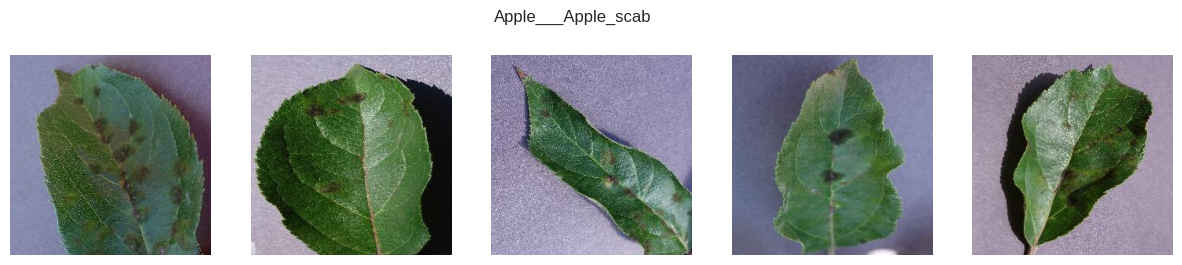

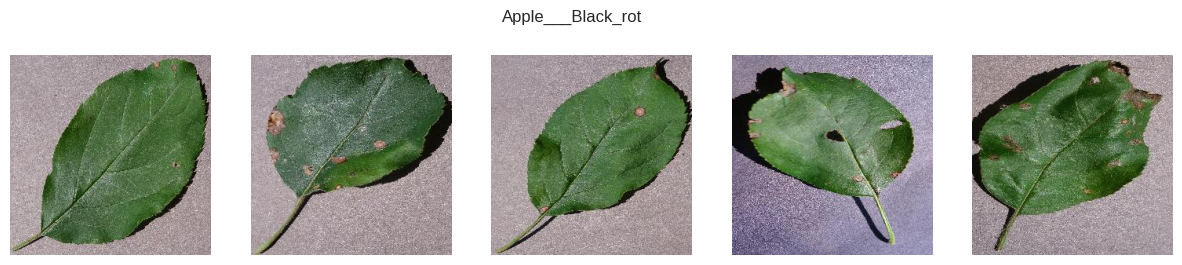

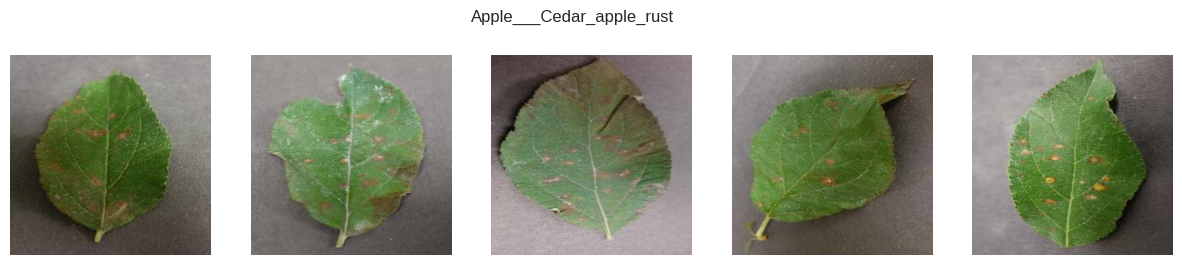

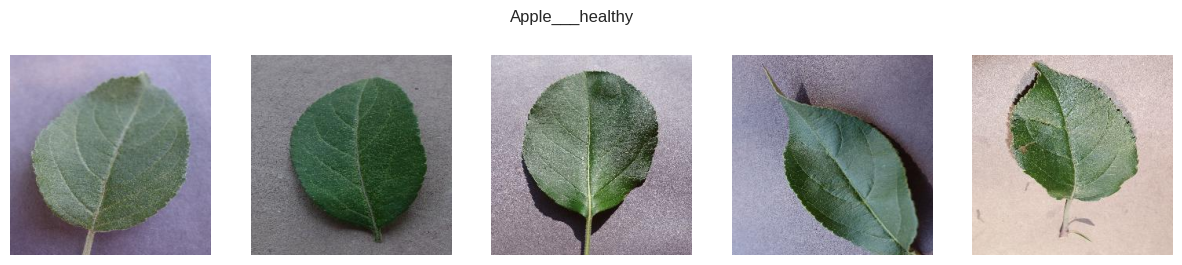

In [5]:
def show_images(class_name, n=5):
    imgs = df[df["class"] == class_name]["image_path"].sample(n)
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(imgs):
        img = Image.open(path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(class_name)
    plt.show()

# Show for 3–4 representative classes
for cls in classes[:4]:
    show_images(cls, n=5)


### 👆Visual Inspection Insights

Many disease classes share strong visual similarities.
Disease symptoms are often subtle and localized, making this a fine-grained
image classification problem.


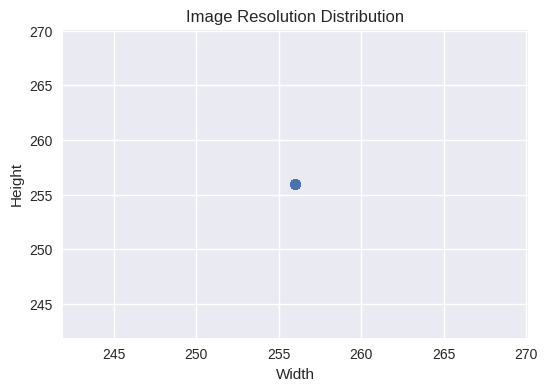

In [6]:
df["aspect_ratio"] = df["width"] / df["height"]

plt.figure(figsize=(6, 4))
plt.scatter(df["width"], df["height"], alpha=0.3)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Resolution Distribution")
plt.show()


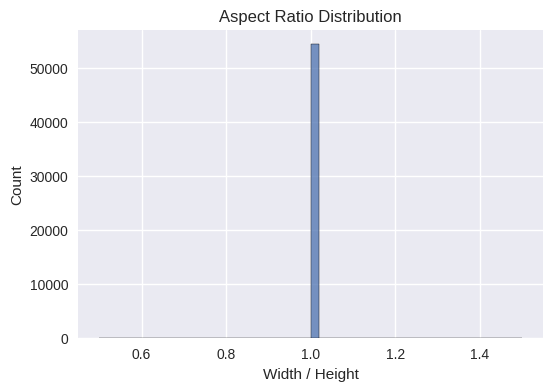

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(df["aspect_ratio"], bins=50)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.show()


###👆 Image Geometry Observations

Most images have similar resolutions and aspect ratios, suggesting that
non-destructive resizing strategies are likely safe.
However, aggressive downscaling may remove small disease-specific features.


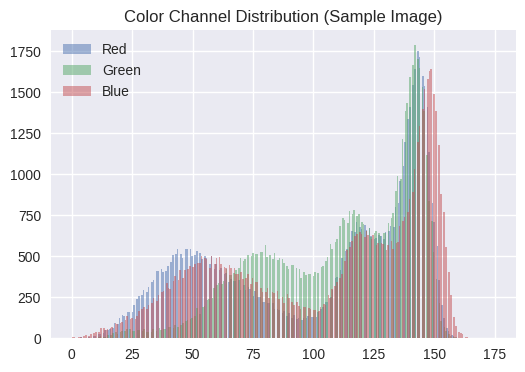

In [8]:
sample_img = Image.open(df.sample(1)["image_path"].values[0])
img_arr = np.array(sample_img)

plt.figure(figsize=(6,4))
plt.hist(img_arr[:,:,0].ravel(), bins=256, alpha=0.5, label="Red")
plt.hist(img_arr[:,:,1].ravel(), bins=256, alpha=0.5, label="Green")
plt.hist(img_arr[:,:,2].ravel(), bins=256, alpha=0.5, label="Blue")
plt.legend()
plt.title("Color Channel Distribution (Sample Image)")
plt.show()


## Key Takeaways from EDA

1. The dataset exhibits class imbalance, which may bias models toward dominant diseases.
2. Disease symptoms are subtle and localized, making classification challenging.
3. Images are relatively clean and well-lit, which may reduce robustness to real-world conditions.
4. Image resolutions are mostly consistent, simplifying preprocessing decisions.


#    Week 2: The Shallow Baseline Challenge


In [9]:
import os
import numpy as np
from PIL import Image

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
TARGET_SIZE = (64, 64)  # Resize images to this small size
DATASET_PATH = "/kaggle/input/plantvillage-dataset/color"

###  Imports & Configuration

We import only essential libraries:
- **PIL(Python Imaging Library)** for reading and resizing images
- **NumPy** for numerical arrays
- **scikit-learn** for baseline models and evaluation
- **Matplotlib/Seaborn** for diagnostics

We also define a fixed image size (`64×64`) to control feature dimensionality.
This keeps classical ML models computationally feasible.


In [10]:
def load_data(directory, target_size):
    X = []
    y = []
    
    # Walk through each folder (class)
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        
        # Skip if it's not a folder
        if not os.path.isdir(class_path):
            continue
        
        print(f"Processing class: {label}...")
        
        # Loop through images in the folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                # 1. Read Image
                img = Image.open(img_path).convert("RGB")
                
                # 2. Resize Image
                img = img.resize(target_size)
                
                # 3. Flatten Image (The "Shallow" Step)
                # (64, 64, 3) -> becomes a list of 12,288 numbers
                img_array = np.array(img)
                feature_vector = img_array.flatten()
                
                X.append(feature_vector)
                y.append(label)
            
            except Exception as e:
                print(f"Skipping error image: {img_name}")
                continue
    
    return np.array(X), np.array(y)


###  Loading Images as Feature Vectors

This function converts the image dataset into a machine-learning friendly format.

Steps:
1. Traverse each folder (each folder = one class label)
2. Read and resize every image
3. Convert the image into a NumPy array
4. **Flatten the 3D image into a 1D feature vector**

This step enforces the **shallow ML constraint**:
> Classical models cannot process spatial structure — only numbers.


In [11]:
# Step A: Prepare Data

# 1. Load the raw data
print("Loading data... this may take a minute.")
X, y = load_data(DATASET_PATH, TARGET_SIZE)
print(f"Raw Data Shape: {X.shape}") 


# 2. Scale the Data 
# This centers data around 0. Crucial if we ever swap RF for SVM.
print("Scaling data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Keeps the class balance equal in train/test
)

print(f"Training on {len(X_train)} images.")
print(f"Testing on {len(X_test)} images.")

Loading data... this may take a minute.
Processing class: Tomato___Late_blight...
Processing class: Tomato___healthy...
Processing class: Grape___healthy...
Processing class: Orange___Haunglongbing_(Citrus_greening)...
Processing class: Soybean___healthy...
Processing class: Squash___Powdery_mildew...
Processing class: Potato___healthy...
Processing class: Corn_(maize)___Northern_Leaf_Blight...
Processing class: Tomato___Early_blight...
Processing class: Tomato___Septoria_leaf_spot...
Processing class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot...
Processing class: Strawberry___Leaf_scorch...
Processing class: Peach___healthy...
Processing class: Apple___Apple_scab...
Processing class: Tomato___Tomato_Yellow_Leaf_Curl_Virus...
Processing class: Tomato___Bacterial_spot...
Processing class: Apple___Black_rot...
Processing class: Blueberry___healthy...
Processing class: Cherry_(including_sour)___Powdery_mildew...
Processing class: Peach___Bacterial_spot...
Processing class: Apple_

#  Dataset Preparation

We load all images and labels into arrays:
- `X` → flattened pixel vectors
- `y` → class labels derived from folder names

The dataset is split into:
- **80% training data**
- **20% test data**

Stratified splitting preserves class balance across both sets.


In [12]:
# Step B: Level 1 Baseline (Dummy)

print("--- Level 1: Dummy Baseline ---")

# Create a model that just guesses the most common label
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

# Predict and Evaluate
dummy_preds = dummy_model.predict(X_test)
dummy_accuracy = accuracy_score(y_test, dummy_preds)

print(f"Dummy Accuracy (The Floor): {dummy_accuracy:.4f}")
print("NOTE: Your actual model MUST beat this score.")

--- Level 1: Dummy Baseline ---
Dummy Accuracy (The Floor): 0.1015
NOTE: Your actual model MUST beat this score.


# Level 1 Baseline (The Floor)

**Logic:** Before we build intelligence, we must measure "zero intelligence."
A **Dummy Classifier** is a model that ignores the input image completely and just guesses the most common label every single time. 

* **Why do this?** This establishes the "Floor."
* **The Rule:** If our  advanced Neural Network cannot beat this number, it is broken.

**Example:** If 60% of  leaves are "Healthy," a model that always guesses "Healthy" gets 60% accuracy. That is not skill; that is probability.

In [13]:
# Step C :Level 2 Baseline (Random Forest)

print("--- Level 2: Shallow Learning (Random Forest) ---")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    n_jobs=-1,         # Use all CPU cores
    random_state=42
)

# Train the model
print("Training Random Forest... (this might take a moment)")
rf_model.fit(X_train, y_train)

# Predict on Test Set
rf_preds = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

--- Level 2: Shallow Learning (Random Forest) ---
Training Random Forest... (this might take a moment)
Random Forest Accuracy: 0.7033


# Level 2 Baseline (The Standard)

**Logic:** Now we apply "Shallow Learning" using the **Random Forest** you learned in Week 2. 
This model is powerful, but it has a fatal flaw for images: it requires **flattening** the data. It treats a leaf image as a long string of unrelated pixels, destroying shapes and spatial patterns.

* **The "Ceiling":** This represents the best performance we can get *without* Deep Learning.
* **The Goal:** Our future CNN (Week 3) must beat this score to justify its complexity.

--- Confusion Matrix ---


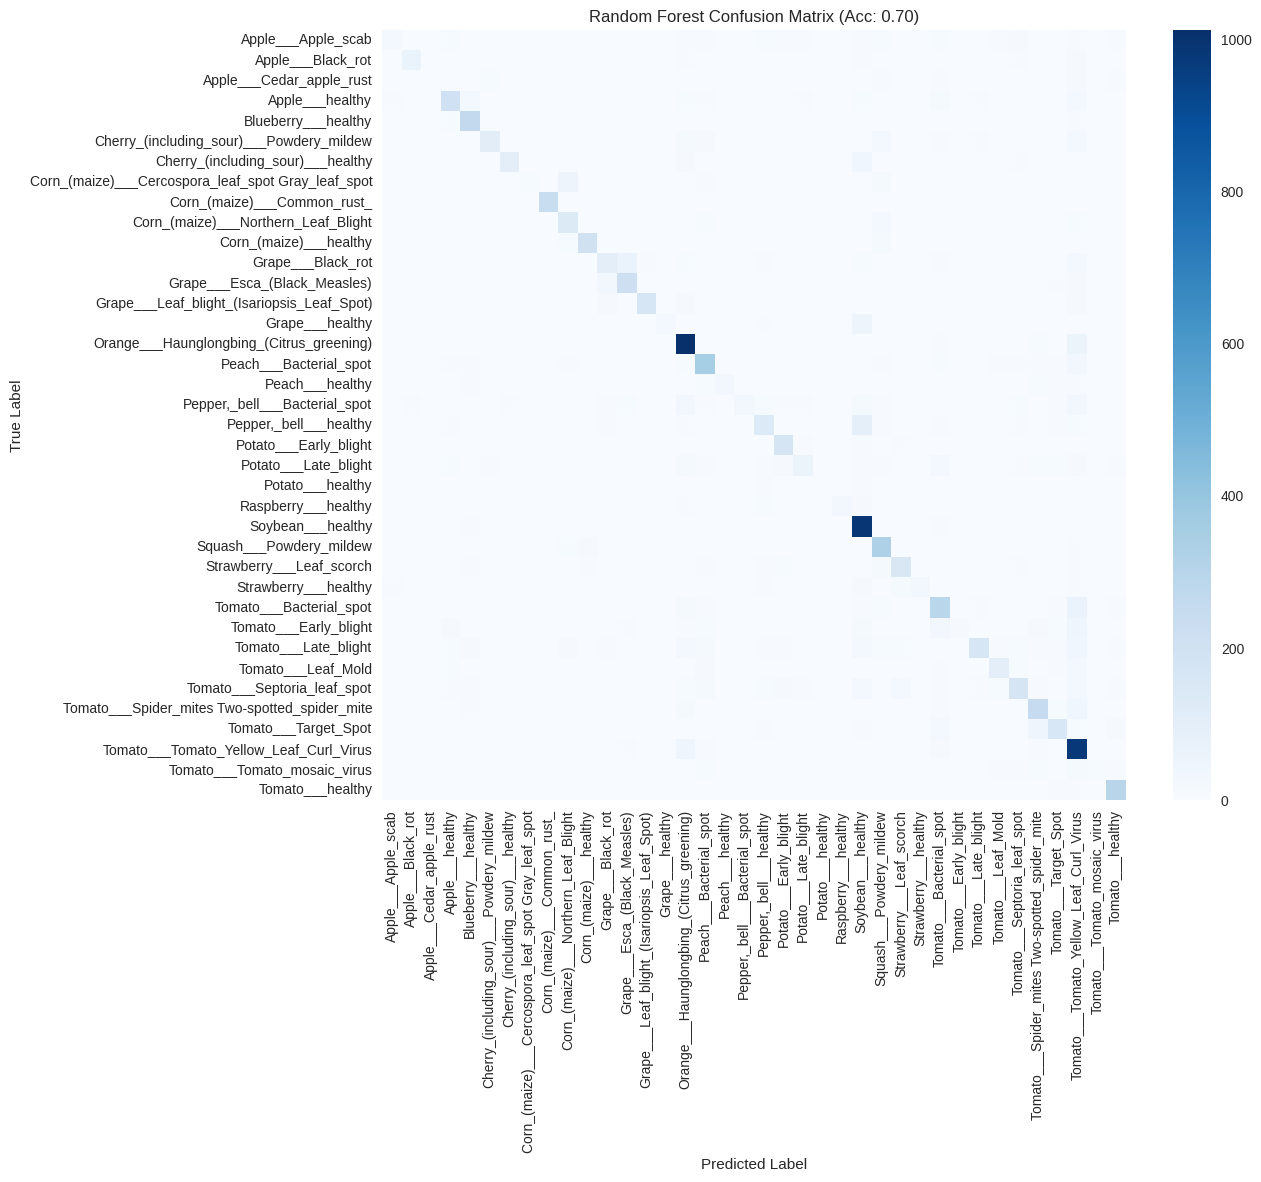

In [14]:
# Step D: Evaluation

print("--- Confusion Matrix ---")

# Calculate Matrix
cm = confusion_matrix(y_test, rf_preds)

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title(f"Random Forest Confusion Matrix (Acc: {rf_accuracy:.2f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)
plt.show()

# Evaluation 

**Logic:** Accuracy numbers hide the truth. A **Confusion Matrix** reveals it.
This heatmap shows us exactly *where* the model is failing.

* **Diagonal Line:** These are correct predictions. We want this dark and heavy.
* **Off-Diagonal Spots:** These are mistakes.

  - Looking  closely we can indentify if  the model confusing similar diseases (e.g., Early Blight vs. Late Blight)?
- If the matrix is a mess, the model is essentially guessing.

**Interpreting the Plot:**
* **X-Axis:** What the model *thought* it was.
* **Y-Axis:** What it *actually* was.

#    Week 3 : The Shallow Baseline Challenge

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report



2026-01-16 16:15:56.554860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768580156.567702     107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768580156.571263     107 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768580156.581373     107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768580156.581388     107 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768580156.581390     107 computation_placer.cc:177] computation placer alr

# Importing  & Global Configuration



* TensorFlow/Keras:The library for Deep Learning (Neural Networks).
* MobileNetV2: Acts like the  "Expert Brain" (pretrained CNN) that we will use later.
* sklearn: use this for evaluation metrics



In [16]:
IMAGE_SIZE = (224,224)
BATCH_SIZE =32
EPOCHS =10
DATA_DIR ="/kaggle/input/plantvillage-dataset/color"



# Defining Constants

**Why 224 × 224?**

* Most modern pretrained models (like MobileNet, ResNet, VGG) were designed to "see" images at this specific resolution.
*  In Week 2, we flattened images into 1D vectors. Here, we keep the **Height** and **Width** (2D) to preserve the shape of the leaf.

In [17]:
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", NUM_CLASSES)




Found 54305 files belonging to 38 classes.
Using 43444 files for training.


2026-01-16 16:16:09.948583: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 54305 files belonging to 38 classes.
Using 10861 files for validation.
Classes: 38


#  Loading  Dataset (The Batch Loader)


In Week 2, you wrote a manual `for` loop to open files one by one.
Here, we use `image_dataset_from_directory`, which creates a **Pipeline**.

* **Batches vs. Individual:** It doesn't load 50,000 images into RAM at once (which would crash the  laptop). It loads them in small "batches" (groups of 32) as the model needs them.
* **Critical Insight:** The labels are still derived automatically from the folder names. If  the  folders are messy, the  model is messy.

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])



#  Data Augmentation (The Teacher)

**Why do we need this?**
Your model is lazy. If you show it a leaf that is always upright, it will memorize "upright = healthy."
**Augmentation** forces the model to learn **Invariance**:
* A leaf is still a leaf if it is upside down.
* A leaf is still a leaf if it is zoomed in.

**Neptune Connection:**
This artificially expands the "support" of our data distribution, preventing the model from memorizing specific pixels (Overfitting).

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (x /255.0, y))
val_ds = val_ds.map(lambda x, y: (x /255.0, y))

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)



#  Normalize Images

**The Math:**
We divide by `255.0` to squash pixel values from `[0, 255]` down to `[0, 1]`.

**Why?**
* **Gradient Stability:** Neural networks learn by making tiny adjustments. Large input numbers (like 255) cause "exploding" math errors. Small numbers (0-1) keep the math stable.
* as we saw in week 2 ,  this is the Deep Learning equivalent of `StandardScaler`.

In [20]:
simple_cnn = models.Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,

    layers.Conv2D(32,3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64,3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

simple_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

simple_cnn.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,912,294 (91.22 MB)

 Trainable params: 23,912,294 (91.22 MB)

 Non-trainable params: 0 (0.00 B)

#  Building Simple CNN (The "Baby" Brain)

**Architecture:**
* **Conv2D:** The "Eye." It scans for edges, colors, and textures.
* **MaxPooling:** The "Summarizer." It shrinks the image, keeping only the most important features.
* **Flatten:** The bridge between the visual part (3D) and the decision part (1D).

**Expected Behavior:**
This model is small and trained from scratch. We can expect it to learn fast but also **overfit** fast. It will likely memorize the training data rather than understanding the concepts.

In [22]:
history_cnn = simple_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)



Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1501s 1s/step - accuracy: 0.4700 - loss: 1.9597 - val_accuracy: 0.7625 - val_loss: 0.7905
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1562s 1s/step - accuracy: 0.7832 - loss: 0.7148 - val_accuracy: 0.8237 - val_loss: 0.5633
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1490s 1s/step - accuracy: 0.8420 - loss: 0.5217 - val_accuracy: 0.8419 - val_loss: 0.5132
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1485s 1s/step - accuracy: 0.8593 - loss: 0.4504 - val_accuracy: 0.8372 - val_loss: 0.5284
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1519s 1s/step - accuracy: 0.8791 - loss: 0.3801 - val_accuracy: 0.8613 - val_loss: 0.4380
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1461s 1s/step - accuracy: 0.8960 - loss: 0.3277 - val_accuracy: 0.8676 - val_loss: 0.4283
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1541s 1s/step - accuracy: 0.9040 - loss: 0.2960 - val_accuracy: 0.8930 - val_loss: 0.3448
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1454s 1s/step - accuracy: 0.9180 -

#   Training  Simple CNN


* We are establishing a baseline.


In [ ]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable =False



#  Load Pretrained Backbone


We downloaded **MobileNetV2**, a model already trained on **1.4 million images** (ImageNet).

* **The Backbone:** We kept the "eyes" (the layers that detect shapes/patterns).
* **`include_top=False`:** We cut off the "head" (the part that classifies dogs/cats) so we can add our own "Plant Disease" head.
* **`trainable = False`:** We **FREEZE** the backbone. We don't want to break its pre-learned intelligence while we train our new layers.

In [ ]:
transfer_model = models.Sequential([
    layers.Input(shape=(224,224,3)),
    data_augmentation,
    preprocess_input,

    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

transfer_model.summary()



#  Building the  Transfer Learning Model

**The Upgrade:**
* **GlobalAveragePooling2D:** A smarter alternative to `Flatten`. Instead of stacking all pixels, it averages the features. This drastically reduces the number of parameters, making the model lighter and harder to overfit.
* **Preprocess Input:** MobileNet has its own specific way of seeing colors. We must use its specific preprocessor to match how it was originally trained.

In [ ]:
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)



# Training the  Transfer Learning Model

**Expected Result:**
* **Speed:** Because the "backbone" is frozen, we are only training a few small layers at the end. It should be very fast.
* **Accuracy:** we should see a significant jump in Validation Accuracy compared to our Simple CNN. This is the power of "Standing on the shoulders of giants."

In [ ]:
y_true = np.concatenate([yfor x, yin val_ds])
y_pred = np.argmax(transfer_model.predict(val_ds), axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix — Transfer Learning")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))



# Evaluation & Confusion Matrix

the **Confusion Matrix** helps to understand where the model fails.

* **Visual Similarity:** Deep Learning models are visual. They will likely confuse diseases that look similar (e.g., two types of "Blight") even if they are on different plants.
* **Week 1 Insight:** If your matrix is messy, revisit your class distribution. Imbalanced classes often lead to a biased matrix.

# Reflection & Deliverables

**Key Takeaways:**
1.  **The Failure of Shallow:** Week 2 models failed because flattening destroyed the spatial "shape" of the disease.
2.  **The Limit of Scratch:** Our Simple CNN worked better, but lacked the "experience" to generalize well (overfitting).
3.  **The Power of Transfer:** Using MobileNet allowed us to leverage millions of pre-learned patterns, boosting accuracy with less data and less training time.

WEE